### Training and Evaluation of datasets

#### Loading train and test data set 

In [1]:
from datetime import datetime
import numpy as np
import tensorflow as tf

print(str(datetime.now()) + ': loading data files')
# Data sets
trainDataFileName = './training/train.csv'
testDataFileName = './testing/test.csv'

2022-01-15 17:29:18.358195: loading data files


### Define training parameters

In [8]:
trainData = tf.contrib.learn.datasets.base.load_csv_without_header(
    filename=trainDataFileName,
    target_dtype=np.int,
    features_dtype=np.int)
testData = tf.contrib.learn.datasets.base.load_csv_without_header(
    filename=testDataFileName,
    target_dtype=np.int,
    features_dtype=np.int)
# validationData = tf.contrib.learn.datasets.base.load_csv_without_header(
#     filename=validationDataFileName,
#     target_dtype=np.int,
#     features_dtype=np.int)

trainingSteps = 1000
totalTrainingSteps = 5000

featureColumns = [tf.contrib.layers.real_valued_column("", dimension=75)]
hiddenUnits = [100, 150, 100, 50]
classes = 2
modelDir = 'model_new'

#### Load DNN classifier and train

In [9]:
classifierConfig = tf.contrib.learn.RunConfig(save_checkpoints_secs = None, save_checkpoints_steps = trainingSteps)

classifier = tf.contrib.learn.DNNClassifier(feature_columns = featureColumns,
                                                hidden_units = hiddenUnits,
                                                n_classes = classes,
                                                model_dir = modelDir,
                                                config = classifierConfig)

# Define the training inputs
def getTrainData():
    x = tf.constant(trainData.data)
    y = tf.constant(trainData.target)
    return x, y

# Define the test inputs
def getTestData():
    x = tf.constant(testData.data)
    y = tf.constant(testData.target)
    return x, y

print(str(datetime.now()) + ': training...')
classifier.fit(input_fn=getTrainData, steps=totalTrainingSteps)
print(str(datetime.now()) + ': testing...')
accuracy = classifier.evaluate(input_fn=getTestData, steps=1)['accuracy']
print(str(datetime.now()) + ': done')
print(str(datetime.now()) + ': accuracy:', accuracy)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001DFBE08A1C8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': 1000, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'model_new', '_session_creation_timeout_secs': 7200}
2022-01-16 11:28:48.901293: training...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done run

### Evaluation metrics on test data

In [14]:
accuracy = 0.7922672
auc = 0.8529307
auc_precision_recall = 0.6924184
precision = 0.707369
recall = 0.6426654

In [15]:
f1_score = 2*precision*recall/(precision+recall)

In [16]:
print("Accuracy-{},AUC:{},precision:{},recall:{},f1-score:{}".format(accuracy,auc,precision,recall,f1_score))

Accuracy-0.7922672,AUC:0.8529307,precision:0.707369,recall:0.6426654,f1-score:0.673466663268136


### Predict Sample image

In [22]:
from datetime import datetime
from PIL import Image
import sys
import numpy as np
import tensorflow as tf


rectSize = 5;

inputImagePath = r'C:\Users\CH514TF\Downloads\archive\road_segmentation_ideal\test_images\input\img-1.png'
inputImage = Image.open(inputImagePath)
inputImageXSize, inputImageYSize = inputImage.size

outputImagePath = r'C:\Users\CH514TF\Downloads\archive\road_segmentation_ideal\test_images\output\output.jpg'
outputImage = inputImage.crop((rectSize//2, rectSize//2, inputImageXSize - (rectSize//2), inputImageYSize - (rectSize//2)))
outputImageXSize, outputImageYSize = outputImage.size

print(str(datetime.now()) + ': initializing model...')
featureColumns = [tf.contrib.layers.real_valued_column("", dimension=75)]
hiddenUnits = [100, 150, 100, 50]
classes = 2
classifier = tf.contrib.learn.DNNClassifier(feature_columns = featureColumns,
                                                hidden_units = hiddenUnits,
                                                n_classes = classes,
                                                model_dir = 'model_new')

def extractFeatures():
    features = np.zeros((((inputImageXSize - ((rectSize//2)*2)) * (inputImageYSize - ((rectSize//2)*2))), rectSize*rectSize*3), dtype=np.int)
    rowIndex = 0
    
    for x in range(rectSize//2, inputImageXSize - (rectSize//2)):
        for y in range(rectSize//2, inputImageYSize - (rectSize//2)):            
            rect = (x - (rectSize//2), y - (rectSize//2), x + (rectSize//2) + 1, y + (rectSize//2) + 1)
            subImage = inputImage.crop(rect).load()
            colIndex = 0
            for i in range(rectSize):
                for j in range(rectSize):
                    features[rowIndex, colIndex] = subImage[i, j][0]
                    colIndex += 1
                    features[rowIndex, colIndex] = subImage[i, j][1]
                    colIndex += 1
                    features[rowIndex, colIndex] = subImage[i, j][2]
                    colIndex += 1
            
            rowIndex += 1
    
    return features
    
def constructOutputImage(predictions):
    outputImagePixels = outputImage.load()
    rowIndex = 0
    for x in range(outputImageXSize):
        for y in range(outputImageYSize):
            outputImagePixels[x, y] = ((255, 255, 255) if predictions[rowIndex] else (0, 0, 0))
            rowIndex += 1
        
print(str(datetime.now()) + ': processing image', inputImagePath)
predictions = list(classifier.predict(input_fn=extractFeatures))

print(str(datetime.now()) + ': constructing output image...')
constructOutputImage(predictions)

print(str(datetime.now()) + ': saving output image...')
outputImage.save(outputImagePath)

print(str(datetime.now()) + ': done')

2022-01-16 12:56:24.393705: initializing model...
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001DFC1C65E08>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'model_new', '_session_creation_timeout_secs': 7200}
2022-01-16 12:56:24.413051: processing image C:\Users\CH514TF\Downloads\archive\road_segmentation

In [24]:
import matplotlib.pyplot as plt

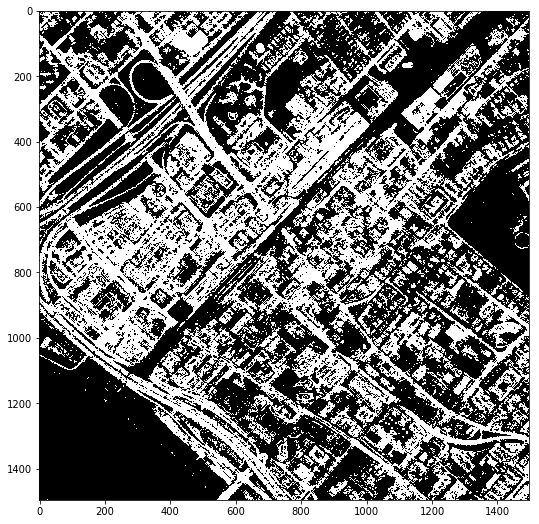

In [25]:
plt.figure(figsize=(15,9))
plt.imshow(outputImage)
plt.show()